In [1]:
pip install category_encoders

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import category_encoders as ce


#### Read dataset

In [4]:
data = pd.read_csv('train.csv')

##### Preprocess data

###### 1. Check for missing values

In [5]:
data.head()
data.shape
features = pd.DataFrame({
    'Count': data.count(),
    'Unique': data.nunique(),
    'Unique Percent': round(((data.nunique()/ data.count()) * 100),2),
    'Null Count': data.isnull().sum(),
    'Null Percent': data.isna().sum()* 100 / data.shape[0],
    'Data Type': data.dtypes
})
print(features)
print(data.describe())

          Count  Unique  Unique Percent  Null Count  Null Percent Data Type
id       193573  193573          100.00           0           0.0     int64
carat    193573     248            0.13           0           0.0   float64
cut      193573       5            0.00           0           0.0    object
color    193573       7            0.00           0           0.0    object
clarity  193573       8            0.00           0           0.0    object
depth    193573     153            0.08           0           0.0   float64
table    193573     108            0.06           0           0.0   float64
x        193573     522            0.27           0           0.0   float64
y        193573     521            0.27           0           0.0   float64
z        193573     349            0.18           0           0.0   float64
price    193573    8738            4.51           0           0.0     int64
                  id          carat          depth          table  \
count  193573.00000

No missing data

###### 2. Check for duplicates

In [6]:
duplicates = data.duplicated()
print(duplicates.loc[duplicates == True])

Series([], dtype: bool)


No duplicates

##### 3. Encode Ordinal features

###### 3.a Ordinal Encoding

In [7]:
cuts = data[['cut', 'color', 'clarity']]
# Worst -> Best: 0, 1, 2...
encoder = OrdinalEncoder(categories=[['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'],
                                     ['J', 'I', 'H', 'G', 'F', 'E', 'D'],
                                     ['I3', 'I2', 'I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF', 'FL']])
# Fit and transform the data
data[['cut', 'color', 'clarity']] = encoder.fit_transform(cuts)


###### 3.b Helmert Encoding

Very poor results

In [8]:
# Very poor results
data_tmp = data.copy()
# Instantiate the encoder
encoder = ce.HelmertEncoder(cols=['cut', 'color', 'clarity'])
# Fit and transform the data
df_encoded = encoder.fit_transform(data_tmp[['cut', 'color', 'clarity']])
price = data_tmp[['price']]
data_tmp.drop(columns=['price'], inplace=True)
data_tmp = data_tmp.join(df_encoded)
data_tmp = data_tmp.join(price)
data_tmp.drop(columns=['cut', 'intercept', 'id', 'color', 'clarity'], inplace=True)
# Print the encoded data
print(data_tmp.head())


C:\Users\dlezo\AppData\Roaming\Python\Python311\site-packages\category_encoders\base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


   carat  depth  table     x     y     z  cut_0  cut_1  cut_2  cut_3  ...  \
0   1.52   62.2   58.0  7.27  7.33  4.55   -1.0   -1.0   -1.0   -1.0  ...   
1   2.03   62.0   58.0  8.06  8.12  5.05    1.0   -1.0   -1.0   -1.0  ...   
2   0.70   61.2   57.0  5.69  5.73  3.50    0.0    2.0   -1.0   -1.0  ...   
3   0.32   61.6   56.0  4.38  4.41  2.71    0.0    2.0   -1.0   -1.0  ...   
4   1.70   62.6   59.0  7.65  7.61  4.77   -1.0   -1.0   -1.0   -1.0  ...   

   color_4  color_5  clarity_0  clarity_1  clarity_2  clarity_3  clarity_4  \
0     -1.0     -1.0       -1.0       -1.0       -1.0       -1.0       -1.0   
1     -1.0     -1.0        1.0       -1.0       -1.0       -1.0       -1.0   
2     -1.0     -1.0        0.0        2.0       -1.0       -1.0       -1.0   
3     -1.0     -1.0        0.0        2.0       -1.0       -1.0       -1.0   
4     -1.0     -1.0       -1.0       -1.0       -1.0       -1.0       -1.0   

   clarity_5  clarity_6  price  
0       -1.0       -1.0  13619  
1 

C:\Users\dlezo\AppData\Roaming\Python\Python311\site-packages\category_encoders\base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


In [9]:
#### 3.5 Remove the id column
data.drop(columns=['id'], inplace=True)

In [10]:
#### 4. Normalize the data in the numerical columns?
# price = data[['price']]
# data = pd.DataFrame(MinMaxScaler().fit_transform(data.iloc[:,:-1]), columns=data.columns[:-1])
# data = data.join(price)
# try:
#     data.drop(columns=['id'], inplace=True)
# except:
#     pass

##### 4. Split between training and test data

In [11]:
# Add price / carat
data['price_carat'] = data['price'] / data['carat']
x_train, x_test, y_train, y_test = train_test_split (data.iloc[:,:-2],data.iloc[:,-2:], test_size=0.3, random_state=42)
# Verify that the split gives similar distributions between train and test on the Ordinal columns
try:
    print(x_train['cut'].value_counts(normalize=True), x_test['cut'].value_counts(normalize=True))
    print(x_train['color'].value_counts(normalize=True), x_test['color'].value_counts(normalize=True))
    print(x_train['clarity'].value_counts(normalize=True), x_test['clarity'].value_counts(normalize=True))
except:
    pass


4.0    0.476417
3.0    0.259459
2.0    0.193386
1.0    0.060184
0.0    0.010553
Name: cut, dtype: float64 4.0    0.480421
3.0    0.254047
2.0    0.195654
1.0    0.059702
0.0    0.010177
Name: cut, dtype: float64
3.0    0.228360
5.0    0.185357
4.0    0.177430
2.0    0.159549
6.0    0.124508
1.0    0.091247
0.0    0.033550
Name: color, dtype: float64 3.0    0.231575
5.0    0.185167
4.0    0.175920
2.0    0.158080
6.0    0.127686
1.0    0.088683
0.0    0.032890
Name: color, dtype: float64
4.0    0.275548
5.0    0.248581
6.0    0.157689
3.0    0.157578
7.0    0.081475
8.0    0.054752
9.0    0.021668
2.0    0.002708
Name: clarity, dtype: float64 4.0    0.274401
5.0    0.247004
6.0    0.160180
3.0    0.157253
7.0    0.081313
8.0    0.055259
9.0    0.022093
2.0    0.002497
Name: clarity, dtype: float64


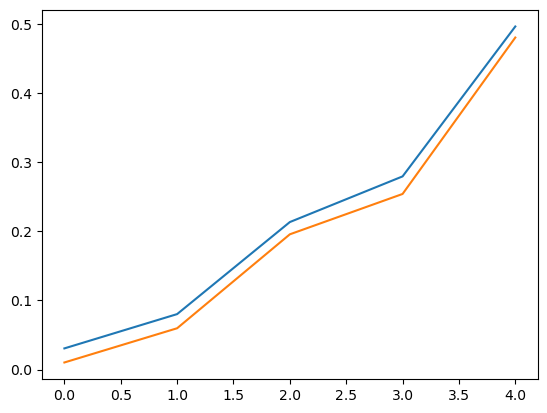

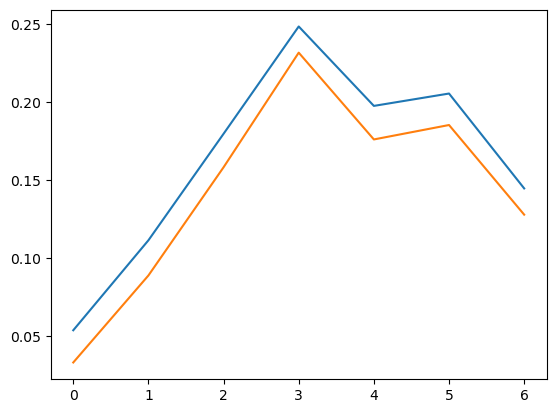

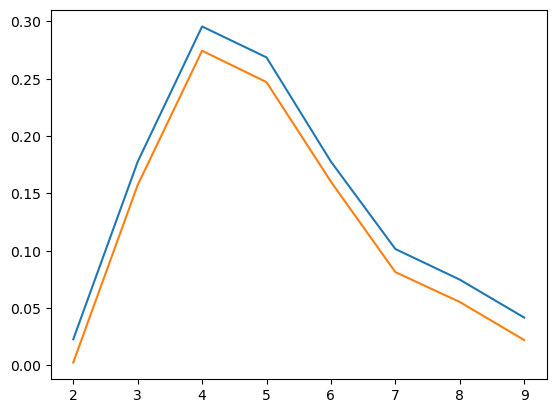

In [12]:
# Also show in plots
plt.figure(1)
plt.plot(x_train['cut'].value_counts(normalize=True, sort=False).sort_index()+0.02)
plt.plot(x_test['cut'].value_counts(normalize=True, sort=False).sort_index())
plt.figure(2)
plt.plot(x_train['color'].value_counts(normalize=True, sort=False).sort_index()+0.02)
plt.plot(x_test['color'].value_counts(normalize=True, sort=False).sort_index())
plt.figure(3)
plt.plot(x_train['clarity'].value_counts(normalize=True, sort=False).sort_index()+0.02)
plt.plot(x_test['clarity'].value_counts(normalize=True, sort=False).sort_index())
plt.show()


               carat            cut          color        clarity  \
count  193573.000000  193573.000000  193573.000000  193573.000000   
mean        0.790688       3.132152       3.483843       4.975084   
std         0.462688       0.994157       1.623091       1.501776   
min         0.200000       0.000000       0.000000       2.000000   
25%         0.400000       2.000000       2.000000       4.000000   
50%         0.700000       3.000000       3.000000       5.000000   
75%         1.030000       4.000000       5.000000       6.000000   
max         3.500000       4.000000       6.000000       9.000000   

               depth          table              x              y  \
count  193573.000000  193573.000000  193573.000000  193573.000000   
mean       61.820574      57.227675       5.715312       5.720094   
std         1.081704       1.918844       1.109422       1.102333   
min        52.100000      49.000000       0.000000       0.000000   
25%        61.300000      56.0000

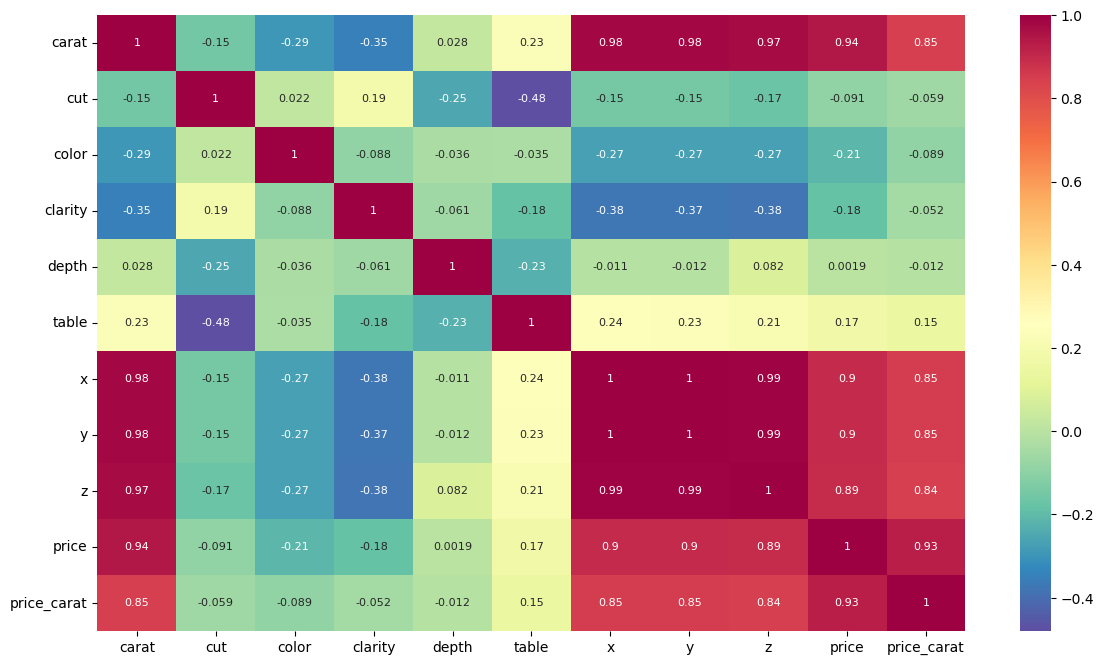

In [13]:
#### 5. Investigate the correlation of the data
print(data.describe())
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix,
            annot=True,
            annot_kws={'size': 8},
            cmap="Spectral_r")
plt.show()


In [14]:
# We see that carat, x, y, z are completely correlated, so we remove x, y & z features
data.drop(columns=['x', 'y', 'z'], inplace=True)
x_train.drop(columns=['x', 'y', 'z'], inplace=True)
x_test.drop(columns=['x', 'y', 'z'], inplace=True)


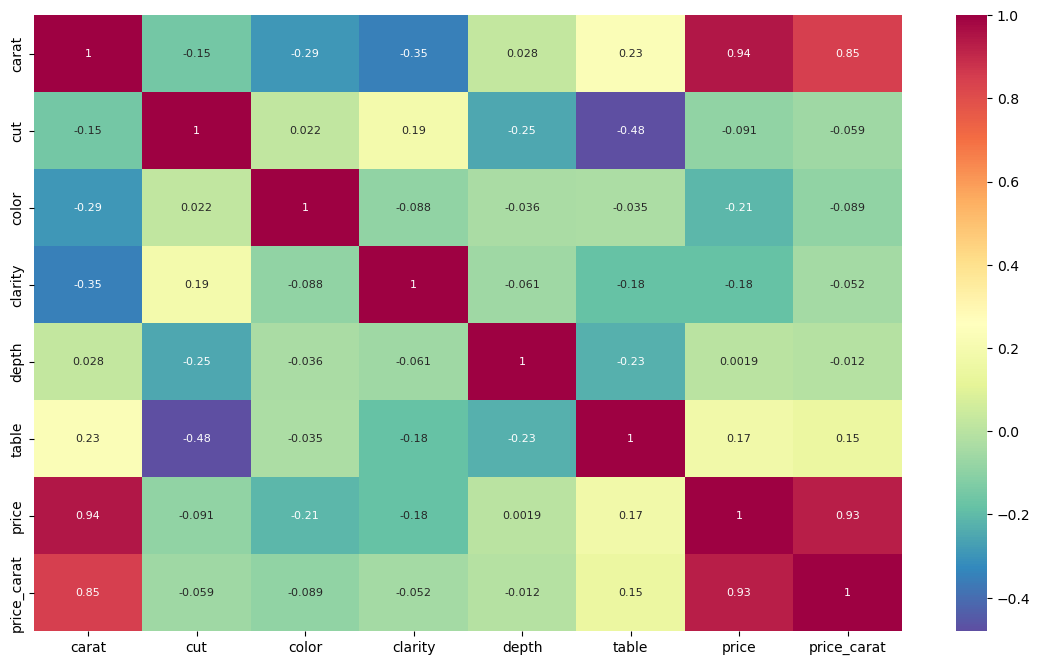

In [15]:
# Let's see the correlation again
corr_matrix = data.corr()
f, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(corr_matrix,
            annot=True,
            annot_kws={'size': 8},
            cmap="Spectral_r")
plt.show()


In [16]:
# Price and carat are very closely correlated as expected we will try to train for two cases:
# a. Price
# b. Price / carat


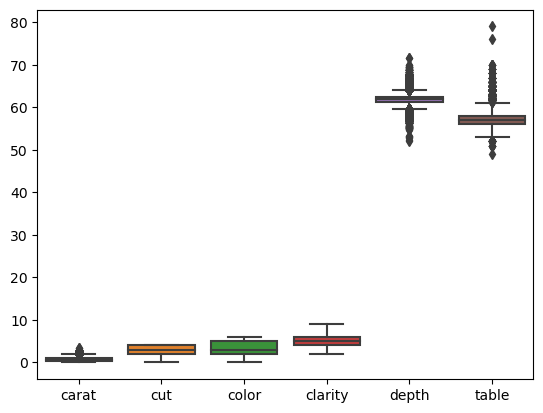

In [17]:
#### 5.5 Boxplots
plt.figure(4)
data_box = data.copy()
try:
    data_box.drop(columns=['price', 'price_carat'], inplace=True)
    data_box.drop(columns=['id'], inplace=True)
except:
    pass
plot = sns.boxplot(data=data_box)
plt.show()


In [18]:
#### 6. Do a simple linear regression for each column
for col in x_train.columns:
    # Create the model
    linear_regression = LinearRegression()
    # training the linear model
    linear_regression.fit(x_train[[col]], y_train['price'])
    # Predict
    y_pred = linear_regression.predict(x_test[[col]])
    # calculating mse
    mse = mean_squared_error(y_test['price'], y_pred)
    print('------------------------')
    print(col, 'linear MSE=', round(mse, 2))
    print(col, 'linear R2=', r2_score(y_test['price'], y_pred))


------------------------
carat linear MSE= 1789347.48
carat linear R2= 0.8892656060475708
------------------------
cut linear MSE= 16037295.85
cut linear R2= 0.007526345295969072
------------------------
color linear MSE= 15434763.74
color linear R2= 0.04481425512190307
------------------------
clarity linear MSE= 15628591.77
clarity linear R2= 0.03281913983366347
------------------------
depth linear MSE= 16159476.41
depth linear R2= -3.484156771138558e-05
------------------------
table linear MSE= 15663665.96
table linear R2= 0.03064856146419892


In [19]:
# For all columns
# Create the model
linear_regression = LinearRegression()
# training the linear model
linear_regression.fit(x_train, y_train['price'])
# Predict
y_pred = linear_regression.predict(x_test)
# calculating mse
mse = mean_squared_error(y_test['price'], y_pred)
print('------------------------')
print('All columns', 'linear MSE=', round(mse, 2))
print('All columns', 'linear R2=', r2_score(y_test['price'], y_pred))


------------------------
All columns linear MSE= 1214741.88
All columns linear R2= 0.9248252745560208


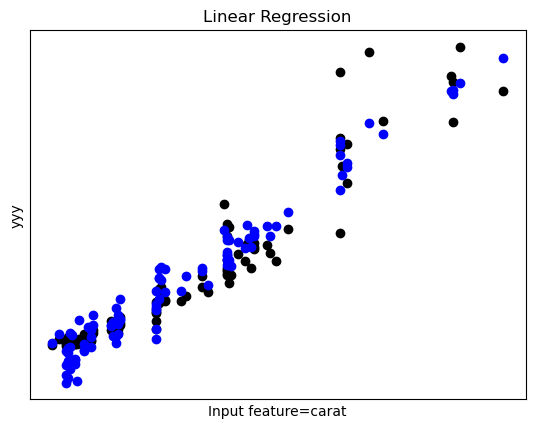

In [20]:
# Plot outputs
plt.figure(1)
plt.title('Linear Regression')
plt.ylabel('yyy')
plt.xlabel('Input feature=carat')
plt.scatter(x_test[:100]['carat'], y_test[:100]['price'],  color='black')
plt.scatter(x_test[:100]['carat'], y_pred[:100], color='blue')
plt.xticks(())
plt.yticks(())
plt.show()


In [21]:
# Try PCA (NOPE!)
pca = PCA()
fit_data = pd.DataFrame(pca.fit_transform(data.iloc[:,1:-1]))
print(pca.explained_variance_ratio_)
x_trainPCA, x_testPCA, y_trainPCA, y_testPCA = train_test_split (fit_data,data.iloc[:,-1:], test_size=0.3, random_state=42)
# Create the model
linear_regression = LinearRegression()
# training the linear model
linear_regression.fit(x_trainPCA, y_trainPCA)
# Predict
y_predPCA = linear_regression.predict(x_testPCA)
# calculating mse
mse = mean_squared_error(y_testPCA, y_predPCA)
mse = mean_squared_error(y_testPCA, y_predPCA)
print('------------------------')
print('All columns PCA', 'linear MSE=', round(mse, 2))
print('All columns PCA', 'linear R2=', r2_score(y_testPCA, y_predPCA))


[9.99999360e-01 2.47302200e-07 1.63405854e-07 1.21416442e-07
 7.91745683e-08 2.86215761e-08]
------------------------
All columns PCA linear MSE= 401576.39
All columns PCA linear R2= 0.897038591688337


In [22]:
#### 7. Do Polynomial linear regression for each column
for col in x_train.columns:
    # Create the model
    linear_regression = LinearRegression()

    poly = PolynomialFeatures(degree=2)
    # features for poly regression
    #x_poly = poly.fit_transform(x_train[[col]])
    # training the linear model
    linear_regression.fit(poly.fit_transform(x_train[[col]]), y_train)
    # Predict
    y_pred = linear_regression.predict(poly.fit_transform(x_test[[col]]))
    # calculating mse
    mse = mean_squared_error(y_test, y_pred)
    print('------------------------')
    print(col, 'polynomial MSE=', round(mse, 2))
    print(col, 'polynomial R2=', r2_score(y_test, y_pred))



------------------------
carat polynomial MSE= 1296340.52
carat polynomial R2= 0.8192660889824849
------------------------
cut polynomial MSE= 9905073.78
cut polynomial R2= 0.010548230907161948
------------------------
color polynomial MSE= 9641756.84
color polynomial R2= 0.027543691519848534
------------------------
clarity polynomial MSE= 9753634.35
clarity polynomial R2= 0.01899868829513185
------------------------
depth polynomial MSE= 10006195.77
depth polynomial R2= 0.0019671056484940608
------------------------
table polynomial MSE= 9701770.08
table polynomial R2= 0.030304603798403384


In [23]:
y_train.head()

,price,price_carat
11504,1181,2880.487805
95284,7418,6030.894309
184777,12755,7502.941176
5419,1020,3090.909091
45466,445,1348.484848


In [24]:
print('# Polynomial regression: ###################')
#degrees = range(2,7)
degrees = range(5,6)
#degrees = range(2,3)
for degree in degrees:
    # For all columns
    # Create the model
    linear_regression = LinearRegression()
    poly = PolynomialFeatures(degree=degree)
    # training the linear model
    linear_regression.fit(poly.fit_transform(x_train), y_train['price'])
    # Predict
    y_pred = linear_regression.predict(poly.fit_transform(x_test))
    # calculating mse
    mse = mean_squared_error(y_test['price'], y_pred)
    print('------------------------')
    print('All columns', 'polynomial', degree, 'MSE=', round(mse, 2))
    print('All columns', 'polynomial', degree, 'R2=', r2_score(y_test['price'], y_pred))


# Polynomial regression: ###################
------------------------
All columns polynomial 5 MSE= 392798.74
All columns polynomial 5 R2= 0.9756915125687226


##### 6. Do a simple linear regression for each column but for price/carat

In [25]:
for col in x_train.columns:
    # Create the model
    linear_regression = LinearRegression()
    # training the linear model
    linear_regression.fit(x_train[[col]], y_train['price_carat'])
    # Predict
    y_pred = linear_regression.predict(x_test[[col]])
    # calculating mse
    mse = mean_squared_error(y_test['price_carat'], y_pred)
    print('------------------------')
    print(col, ' price/carat linear MSE=', round(mse, 2))
    print(col, ' price/carat linear R2=', r2_score(y_test['price_carat'], y_pred))
# For all columns
# Create the model
linear_regression = LinearRegression()
# training the linear model
linear_regression.fit(x_train.drop(columns=['carat']), y_train['price_carat'])
# Predict
y_pred = linear_regression.predict(x_test.drop(columns=['carat']))
# calculating mse
mse = mean_squared_error(y_test['price_carat'], y_pred)
print('------------------------')
print('All columns price/carat', 'linear MSE=', round(mse, 2))
print('All columns price/carat', 'linear R2=', r2_score(y_test['price_carat'], y_pred))


------------------------
carat  price/carat linear MSE= 1102652.41
carat  price/carat linear R2= 0.7172875533057415
------------------------
cut  price/carat linear MSE= 3888275.19
cut  price/carat linear R2= 0.003073147681059041
------------------------
color  price/carat linear MSE= 3868967.69
color  price/carat linear R2= 0.008023458917428838
------------------------
clarity  price/carat linear MSE= 3890287.86
clarity  price/carat linear R2= 0.0025571148614941253
------------------------
depth  price/carat linear MSE= 3899825.16
depth  price/carat linear R2= 0.00011181702988050102
------------------------
table  price/carat linear MSE= 3815874.05
table  price/carat linear R2= 0.02163630019142615
------------------------
All columns price/carat linear MSE= 3779340.31
All columns price/carat linear R2= 0.031003296895519172


In [26]:
#### 7. Do Polynomial linear regression for each column but for price/carat
for col in x_train.columns:
    # Create the model
    linear_regression = LinearRegression()

    poly = PolynomialFeatures(degree=2)
    # features for poly regression
    #x_poly = poly.fit_transform(x_train[[col]])
    # training the linear model
    linear_regression.fit(poly.fit_transform(x_train[[col]]), y_train['price_carat'])
    # Predict
    y_pred = linear_regression.predict(poly.fit_transform(x_test[[col]]))
    # calculating mse
    mse = np.mean((y_pred - y_test['price_carat']) ** 2)
    mse = mean_squared_error(y_test['price_carat'], y_pred)
    print('------------------------')
    print(col, 'polynomial price_carat MSE=', round(mse, 2))
    print(col, 'polynomial price_carat R2=', r2_score(y_test['price_carat'], y_pred))


------------------------
carat polynomial price_carat MSE= 1033474.86
carat polynomial price_carat R2= 0.7350241970981533
------------------------
cut polynomial price_carat MSE= 3871031.94
cut polynomial price_carat R2= 0.007494198296068899
------------------------
color polynomial price_carat MSE= 3863834.28
color polynomial price_carat R2= 0.009339627535179917
------------------------
clarity polynomial price_carat MSE= 3880506.36
clarity polynomial price_carat R2= 0.00506502200024761
------------------------
depth polynomial price_carat MSE= 3894919.48
depth polynomial price_carat R2= 0.001369599008267497
------------------------
table polynomial price_carat MSE= 3797257.46
table polynomial price_carat R2= 0.026409463253017185


In [27]:
print('# Polynomial regression: ###################')
for degree in degrees:
    # For all columns
    # Create the model
    linear_regression = LinearRegression()
    poly = PolynomialFeatures(degree=degree)
    # training the linear model
    linear_regression.fit(poly.fit_transform(x_train.drop(columns=['carat'])), y_train['price_carat'])
    # Predict
    y_pred = linear_regression.predict(poly.fit_transform(x_test.drop(columns=['carat'])))
    # calculating mse
    mse = mean_squared_error(y_test['price'], y_pred)
    print('------------------------')
    print('All columns price/carat', 'polynomial', degree, 'MSE=', round(mse, 2))
    print('All columns price/carat', 'polynomial', degree, 'R2=', r2_score(y_test['price_carat'], y_pred))


# Polynomial regression: ###################
------------------------
All columns price/carat polynomial 5 MSE= 15790590.06
All columns price/carat polynomial 5 R2= -0.08235906576786611


##### 8 Ridge for polynomial degree 5

In [28]:
poly = PolynomialFeatures(degree=5)
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(poly.fit_transform(x_train), y_train['price'])
y_pred = ridge_regression.predict(poly.fit_transform(x_test))
# calculating mse
mse = mean_squared_error(y_test['price'], y_pred)
print('------------------------')
print('All columns Ridge MSE=', round(mse, 2))
print('All columns Ridge R2=', r2_score(y_test['price'], y_pred))

------------------------
All columns Ridge MSE= 387665.71
All columns Ridge R2= 0.9760091719338535


##### 9 Lasso for polynomial degree 2

In [29]:
poly = PolynomialFeatures(degree=2)
lasso_regression = Lasso(alpha=0.1)
lasso_regression.fit(poly.fit_transform(x_train), y_train['price'])
y_pred = lasso_regression.predict(poly.fit_transform(x_test))
# calculating mse
mse = mean_squared_error(y_test['price'], y_pred)
print('------------------------')
print('All columns Lasso MSE=', round(mse, 2))
print('All columns Lasso R2=', r2_score(y_test['price'], y_pred))

------------------------
All columns Lasso MSE= 583254.38
All columns Lasso R2= 0.9639050987707488


C:\Software\Anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.978e+10, tolerance: 2.212e+08
  model = cd_fast.enet_coordinate_descent(


##### 10 Backward Stepwise Polynomial regression

In [30]:
x_train_drop = x_train.copy()
x_test_drop = x_test.copy()

for column in ['depth', 'cut', 'table', 'clarity', 'color']:
    x_train_drop.drop(columns=[column], inplace=True)
    x_test_drop.drop(columns=[column], inplace=True)
    for degree in degrees: #range(2,6):
        # For all columns
        # Create the model
        linear_regression = LinearRegression()
        poly = PolynomialFeatures(degree=degree)
        # training the linear model
        linear_regression.fit(poly.fit_transform(x_train_drop), y_train['price'])
        # Predict
        y_pred = linear_regression.predict(poly.fit_transform(x_test_drop))
        # calculating mse
        mse = mean_squared_error(y_test['price'], y_pred)
        print('------------------------')
        print(x_train_drop.columns, 'polynomial', degree, 'MSE=', round(mse, 2))
        print(x_train_drop.columns, 'polynomial', degree, 'R2=', r2_score(y_test['price'], y_pred))


------------------------
Index(['carat', 'cut', 'color', 'clarity', 'table'], dtype='object') polynomial 5 MSE= 387888.13
Index(['carat', 'cut', 'color', 'clarity', 'table'], dtype='object') polynomial 5 R2= 0.9759954074245801
------------------------
Index(['carat', 'color', 'clarity', 'table'], dtype='object') polynomial 5 MSE= 420226.05
Index(['carat', 'color', 'clarity', 'table'], dtype='object') polynomial 5 R2= 0.9739941639738643
------------------------
Index(['carat', 'color', 'clarity'], dtype='object') polynomial 5 MSE= 402397.52
Index(['carat', 'color', 'clarity'], dtype='object') polynomial 5 R2= 0.9750974891869061
------------------------
Index(['carat', 'color'], dtype='object') polynomial 5 MSE= 1069897.03
Index(['carat', 'color'], dtype='object') polynomial 5 R2= 0.9337890488091292
------------------------
Index(['carat'], dtype='object') polynomial 5 MSE= 1376505.37
Index(['carat'], dtype='object') polynomial 5 R2= 0.9148144841434129


###### 11 Combine the above results for the best case:
    Ridge, Polynomial degree 5 and ['cut', 'table', 'clarity', 'color', 'carat'] columns

In [32]:
x_train_drop = x_train.drop(columns=['depth'])
x_test_drop = x_test.drop(columns=['depth'])
poly = PolynomialFeatures(degree=5)
ridge_regression = Ridge(alpha=0.1)
ridge_regression.fit(poly.fit_transform(x_train_drop), y_train['price'])
y_pred = ridge_regression.predict(poly.fit_transform(x_test_drop))
# calculating mse
mse = mean_squared_error(y_test['price'], y_pred)
print('------------------------')
print('All columns Ridge without ''depth'' MSE=', round(mse, 2))
print('All columns Ridge without ''depth'' R2=', r2_score(y_test['price'], y_pred))

------------------------
All columns Ridge without depth MSE= 387366.34
All columns Ridge without depth R2= 0.9760276984604495


C:\Software\Anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=3.95654e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


#### Finally try the use of a NN

In [33]:
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredLogarithmicError, MeanSquaredError


learning_rate = 0.01
# Creating model using the Sequential in tensorflow
model = Sequential([
Dense(100, kernel_initializer='normal', activation='relu'),
Dropout(0.2),
Dense(200, kernel_initializer='normal', activation='relu'),
Dropout(0.2),
Dense(50, kernel_initializer='normal', activation='relu'),
Dense(1, kernel_initializer='normal', activation='linear')
])

# loss function
msle = MeanSquaredLogarithmicError()
mse = MeanSquaredError()
model.compile(
    loss=msle,
    optimizer=Adam(learning_rate=learning_rate),
    #metrics=[msle],
    metrics = [mse],
)

# train the model
history = model.fit(
    x_train.values,
    y_train['price'].values,
    epochs=10,
    batch_size=300,
    validation_split=0.2,
)

y_pred = model.predict(x_test)
# calculating mse
mse = mean_squared_error(y_test['price'], y_pred)
print('------------------------')
print('NN MSE=', round(mse, 2))
print('NN R2=', r2_score(y_test['price'], y_pred))


Epoch 1/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.7934 - mean_squared_error: 19623670.0000 - val_loss: 0.9758 - val_mean_squared_error: 18389312.0000
Epoch 2/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.7816 - mean_squared_error: 15564084.0000 - val_loss: 0.0556 - val_mean_squared_error: 3407857.0000
Epoch 3/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0621 - mean_squared_error: 2446191.0000 - val_loss: 0.0216 - val_mean_squared_error: 880083.9375
Epoch 4/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0387 - mean_squared_error: 1317964.0000 - val_loss: 0.0195 - val_mean_squared_error: 719591.6250
Epoch 5/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0356 - mean_squared_error: 1212382.1250 - val_loss: 0.0203 - val_mean_squared_error: 710329.3125
Epoch 6/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0341 - mean_squared_error: 1143562.2500 - val_loss: 0.0194 - val_mean_squared_error: 702790.4375
Epoch 7/10
362/362 ━━━━━━━━━━━━━━━━━━━━ 1

###### No better results than the best Polynomial Regression